# Lift Testing with Interrupted Time Series: A Marketing Case Study

## Running Lift Tests When You Have No Control Group

In marketing analytics, **lift tests** (also known as incrementality tests) are experiments designed to measure the true causal impact of advertising campaigns. These results are crucial for:
- Validating marketing attribution models
- Calibrating Media Mix Models (MMM) to improve accuracy
- Making informed budget allocation decisions

The gold standard for lift testing is a randomized controlled trial with treatment and control groups. However, this is not always possible. When running **national-level campaigns** (such as TV advertising in the UK), there may be no geographic control group available since the entire market receives the treatment simultaneously.

This notebook demonstrates how to use **Interrupted Time Series (ITS)** analysis to conduct a lift test and generate the statistical outputs needed for downstream applications like MMM calibration. ITS is particularly valuable when:
- You're running national campaigns with no geographic controls
- You need to measure the incremental impact of a campaign above baseline activity
- You want to feed experimental results into your MMM to improve parameter estimates

:::{admonition} Connection to Media Mix Modeling
:class: note

The lift test results from this notebook (mean lift and standard deviation) can be directly integrated into MMM frameworks like [PyMC-Marketing](https://www.pymc-marketing.io/) to calibrate saturation curves and improve attribution accuracy. See the [PyMC-Marketing lift test calibration documentation](https://www.pymc-marketing.io/en/latest/notebooks/mmm/mmm_lift_test.html) for details on how to use these results.
:::


## The Business Scenario

Imagine you are managing marketing for a national brand in the UK. Your marketing mix includes:
- **Baseline TV Brand Awareness**: Continuous, low-level TV spend to maintain brand presence
- **TV Promo Campaign**: A 4-week high-spend campaign for a new product launch or seasonal promotion
- **Digital Paid Advertising**: Ongoing digital marketing efforts  
- **Radio**: Steady radio advertising

The TV promo campaign represents a significant investment - both in producing a new advertisement and in media buying to air it during prime time. The spend during this promotional period is much higher than your baseline TV spend.

**The Challenge**: Because the TV campaign runs nationally, you don't have a clean control group. You can't compare sales in "treated" vs "untreated" regions. 

**The Solution**: Use Interrupted Time Series analysis to fit sales before the campaign. We can then use that model to estimate the counterfactual estimate of what the sales would have been without the campaign. Comparing that and the actual sales gives us an estimate of the causal impact of the promo campaign.


## Lift Test Outputs

A successful lift test provides statistical estimates of campaign effectiveness that can be used for both immediate decision-making and model calibration. Using ITS analysis, we'll generate:

### Primary Lift Test Results (for MMM Calibration)

1. **Absolute Lift with Uncertainty**: The total incremental units (sales, conversions, etc.) attributable to the campaign, expressed as a posterior distribution with **mean** and **standard deviation**. This is the key output needed for MMM calibration.

### Additional Business Metrics

2. **Percentage Lift**: The percentage increase in the outcome variable compared to the counterfactual baseline
3. **Return on Investment (ROI)**: The financial return from the campaign relative to spend

All metrics include full uncertainty quantification through Bayesian inference, providing not just point estimates but complete probability distributions. This uncertainty information is essential for:
- **MMM Calibration**: Informing how strongly the lift test should constrain model parameters
- **Decision Making**: Understanding the range of plausible campaign effects
- **Risk Assessment**: Quantifying confidence in positive/negative ROI


:::{admonition} Structure of This Notebook
:class: tip

This notebook is organized into the following sections:

* **Setup and Imports**: Load required packages
* **Part I: Data Simulation**: Generate synthetic marketing data with realistic patterns
   - Define time periods and intervention dates
   - Create media spend data for multiple channels
   - Apply marketing transformations (adstock and saturation)
   - Construct the target variable (sales)
   
   *Note: If you already have your own data and just want to learn how to evaluate lift, you can skip directly to Part II.*

* **Part II: Interrupted Time Series Analysis**: Fit the ITS model and generate counterfactual predictions
* **Part III: Calculating Lift Metrics**: 
   - Absolute Lift (total incremental sales)
   - Percentage Lift (% increase vs baseline)
   - Return on Investment (ROI)
* **Summary and Interpretation**: Business implications, assumptions, and next steps

:::


## Setup and Imports


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

import causalpy as cp

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Set random seed for reproducibility
seed = 42
rng = np.random.default_rng(seed)

/Users/benjamv/miniforge3/envs/CausalPy/lib/python3.13/site-packages/pymc_marketing/pytensor_utils.py:34: FutureWarning: `pytensor.graph.basic.ancestors` was moved to `pytensor.graph.traversal.ancestors`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import ancestors


## Part I: Data Simulation

For this example, we'll generate synthetic data to illustrate the method. In a real-world scenario, you would use your actual sales and media spend data. 

We'll simulate a simplified Media Mix Model where sales are driven by:
- A linear trend (business growth over time)
- Annual seasonality (monthly patterns)
- Media channel contributions with realistic marketing effects (adstock and saturation)
- Random noise

This simulation will help us demonstrate parameter recovery and validate that ITS can accurately estimate the lift from the TV promo campaign.


### 1. Define Date Range and Intervention Period


In [2]:
# Create date range: 2 years pre-intervention + 3 months post-intervention
# Using weekly data
n_weeks_pre = 104  # 2 years
n_weeks_post = 13  # 3 months (approximately)
n_total = n_weeks_pre + n_weeks_post

# Start date
start_date = pd.Timestamp("2022-01-03")  # Starting on a Monday
date_range = pd.date_range(start=start_date, periods=n_total, freq="W-MON")

# Define intervention start (beginning of TV promo campaign)
intervention_start = date_range[n_weeks_pre]
# Define intervention end (after 4-week promo campaign)
promo_weeks = 4
intervention_end = intervention_start + pd.Timedelta(weeks=promo_weeks)
print(f"Pre-intervention period: {date_range[0]} to {date_range[n_weeks_pre - 1]}")
print(f"Intervention starts: {intervention_start}")
print(f"Intervention ends: {intervention_end}")
print(f"Post-intervention period: {intervention_end} to {date_range[-1]}")
print(f"Total weeks: {n_total}")

Pre-intervention period: 2022-01-03 00:00:00 to 2023-12-25 00:00:00
Intervention starts: 2024-01-01 00:00:00
Intervention ends: 2024-01-29 00:00:00
Post-intervention period: 2024-01-29 00:00:00 to 2024-03-25 00:00:00
Total weeks: 117


### 2. Generate Media Spend Data

We'll create spend data for four media channels, each with realistic patterns.


In [3]:
# Initialize spend arrays
spend_data = {}

# 1. TV Brand Awareness: constant low-level spend throughout
# Baseline TV spend around £20,000/week with small random variation
spend_data["tv_brand_awareness"] = 20_000 + rng.normal(0, 2_000, n_total)
spend_data["tv_brand_awareness"] = np.clip(
    spend_data["tv_brand_awareness"], 15_000, 25_000
)

# 2. TV Promo: zero pre-intervention, high spend for 4 weeks during intervention
spend_data["tv_promo"] = np.zeros(n_total)
# High spend during first 4 weeks of intervention (weeks 104-107)
for i in range(promo_weeks):
    # Promo spend around £50,000/week (much higher than baseline)
    spend_data["tv_promo"][n_weeks_pre + i] = 50_000 + rng.normal(0, 3_000)

# 3. Digital Paid: steady spend with random variation
# Around £30,000/week
spend_data["digital_paid"] = 30_000 + rng.normal(0, 5_000, n_total)
spend_data["digital_paid"] = np.clip(spend_data["digital_paid"], 20_000, 40_000)

# 4. Radio: steady spend with random variation
# Around £15,000/week
spend_data["radio"] = 15_000 + rng.normal(0, 3_000, n_total)
spend_data["radio"] = np.clip(spend_data["radio"], 10_000, 20_000)

# Create dataframe
df_spend = pd.DataFrame(spend_data, index=date_range)
df_spend.head(10)

,tv_brand_awareness,tv_promo,digital_paid,radio
2022-01-03,20609.434160,0.0,30896.378175,11812.756764
2022-01-10,17920.031788,0.0,31099.983420,13411.681718
2022-01-17,21500.902392,0.0,36795.937876,12369.417665
2022-01-24,21881.129433,0.0,34175.556230,14717.212337
2022-01-31,16097.929623,0.0,31784.355296,10000.000000
2022-02-07,17395.640986,0.0,37316.514456,10598.864264
2022-02-14,20255.680806,0.0,24056.184728,20000.000000
2022-02-21,19367.514815,0.0,26801.242336,11137.732256
2022-02-28,19966.397685,0.0,25367.120293,11709.643265
2022-03-07,18293.912145,0.0,28050.950984,20000.000000


Let's visualize the media spend over time, highlighting the TV promo spike:


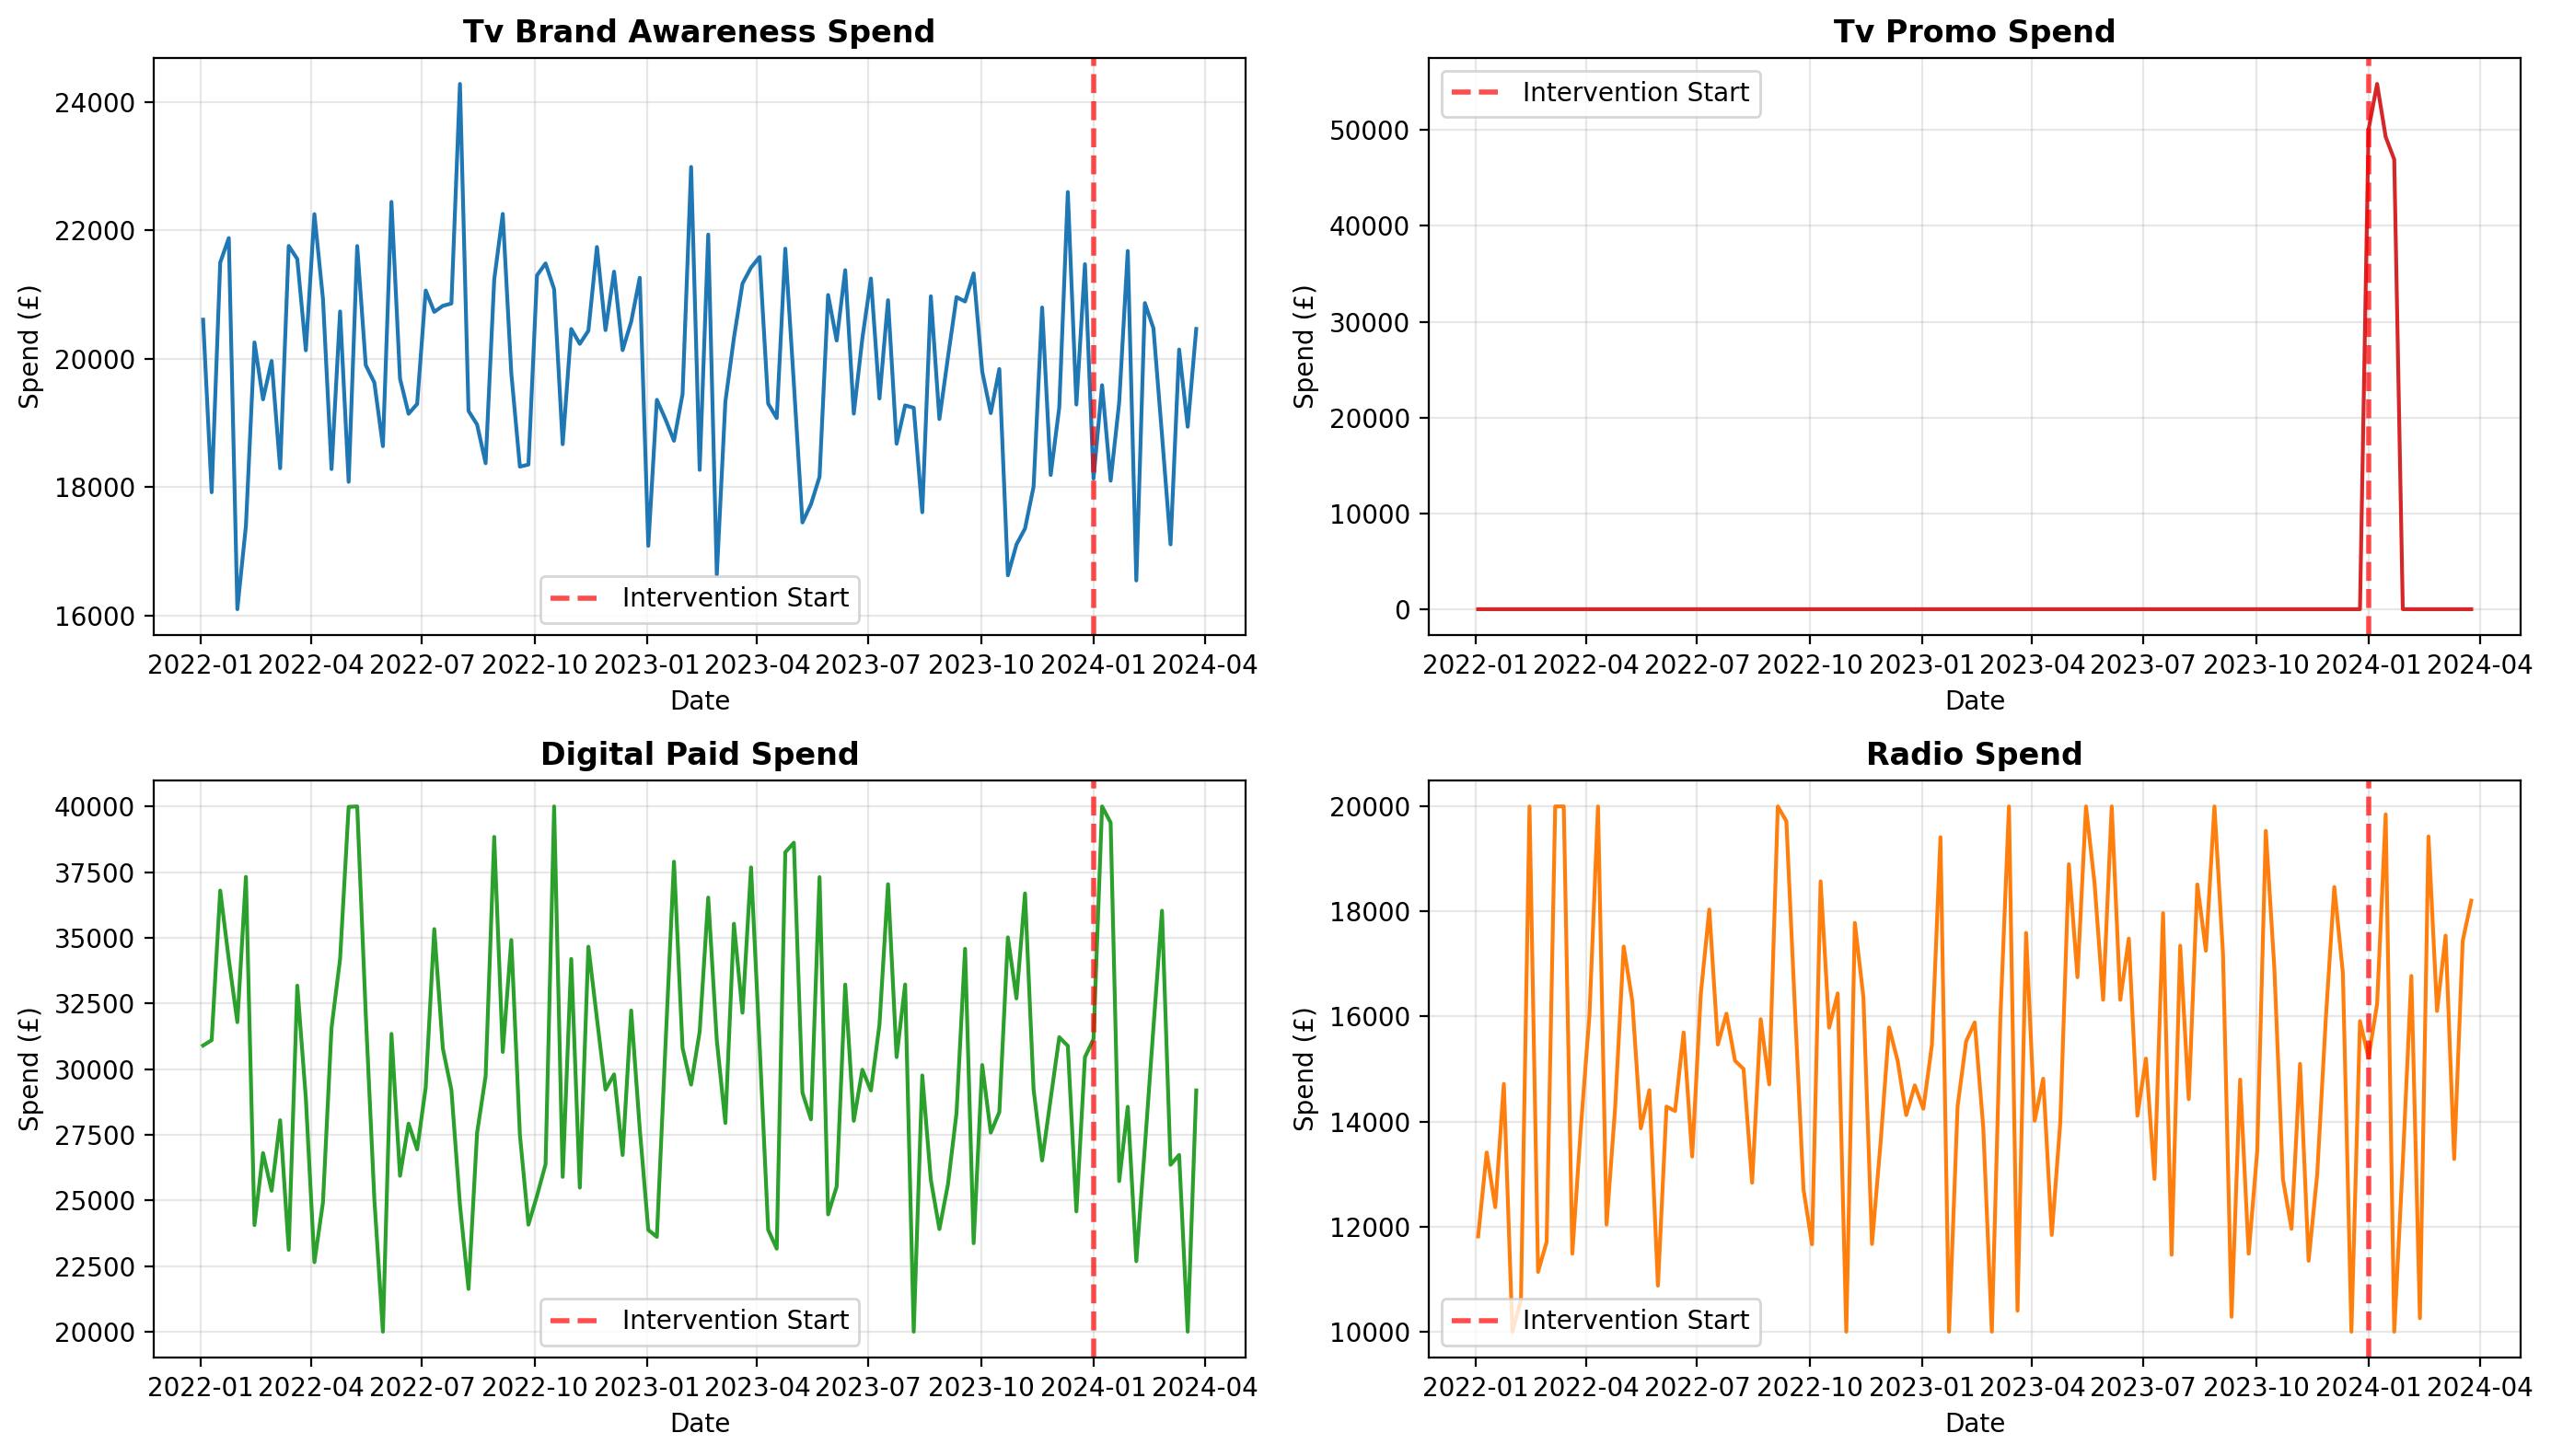

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

channels = ["tv_brand_awareness", "tv_promo", "digital_paid", "radio"]
colors = ["#1f77b4", "#d62728", "#2ca02c", "#ff7f0e"]

for ax, channel, color in zip(axes, channels, colors):
    ax.plot(df_spend.index, df_spend[channel], color=color, linewidth=1.5)
    ax.axvline(
        intervention_start,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label="Intervention Start",
    )
    ax.set_title(
        f"{channel.replace('_', ' ').title()} Spend", fontsize=12, fontweight="bold"
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Spend (£)")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()

### 3. Apply Marketing Transformations

In real-world marketing, media effects are not instantaneous or linear:
- **Adstock Effect**: Media exposure has a carryover effect. When someone sees a TV ad, the impact on their purchase behavior extends beyond that moment and decays over time.
- **Saturation Effect**: There are diminishing returns to advertising spend. Doubling the spend doesn't double the impact.

We'll use transformations from the `pymc-marketing` package to model these effects realistically.


In [5]:
# Define transformation parameters for each channel
# Different channels have different adstock (carryover) and saturation characteristics

# Adstock parameters (alpha): higher = longer carryover effect
# Saturation parameters (lam): controls the inflection point of the saturation curve

channel_params = {
    "tv_brand_awareness": {
        "alpha": 0.6,  # Moderate carryover
        "lam": 0.5,
    },
    "tv_promo": {
        "alpha": 0.7,  # Strong carryover (high impact ads are remembered longer)
        "lam": 0.3,
    },
    "digital_paid": {
        "alpha": 0.3,  # Short carryover (digital is more immediate)
        "lam": 0.6,
    },
    "radio": {
        "alpha": 0.4,  # Moderate carryover
        "lam": 0.7,
    },
}

# Apply transformations to each channel
df_transformed = pd.DataFrame(index=date_range)

for channel in channels:
    # Get channel spend
    spend = df_spend[channel].to_numpy()

    # Scale the spend using max absolute value (brings values to 0-1 range)
    # This is important because saturation functions work best with scaled inputs
    spend_max = spend.max()
    spend_scaled = spend / spend_max if spend_max > 0 else spend

    # Apply Geometric Adstock transformation
    spend_adstocked = geometric_adstock(
        x=spend_scaled, alpha=channel_params[channel]["alpha"]
    ).eval()

    # Apply Logistic Saturation transformation
    spend_transformed = logistic_saturation(
        x=spend_adstocked, lam=channel_params[channel]["lam"]
    ).eval()

    df_transformed[f"{channel}_transformed"] = spend_transformed

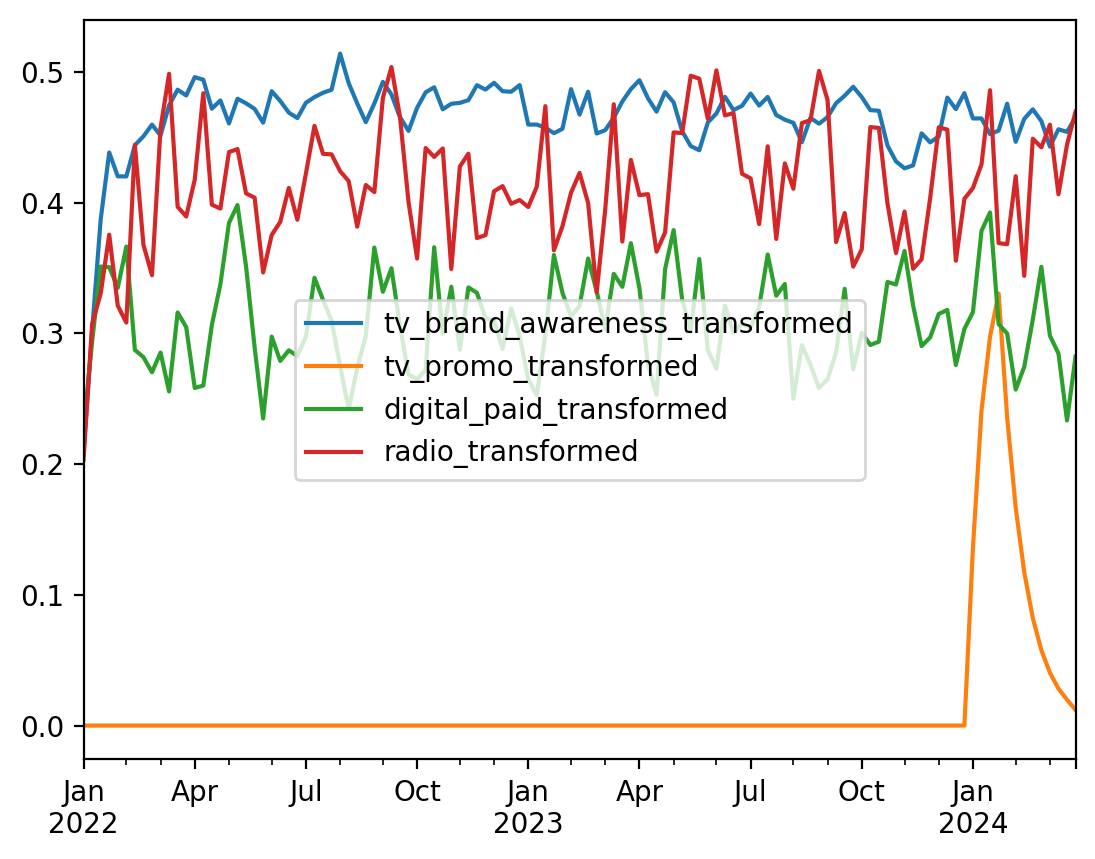

In [6]:
df_transformed.plot();

### 4. Construct the Target Variable (Sales)

Now we'll build our sales data by combining all components. The sales are driven by baseline factors (trend, seasonality) plus the transformed media contributions.


In [7]:
# Create time index for trend
t = np.arange(n_total)

# 1. Baseline intercept (average sales with no marketing)
intercept = 5000

# 2. Linear trend (business growth over time)
trend = 10 * t  # Growing by ~10 units per week

# 3. Annual seasonality (using month of year and week of month)
# Extract month from date_range
months = date_range.month
# Create monthly seasonal component using sine waves
monthly_seasonality = 500 * np.sin(2 * np.pi * months / 12) + 300 * np.cos(
    2 * np.pi * months / 12
)

# Extract week of month (1-5, since no month has more than 31 days)
week_of_month = ((date_range.day - 1) // 7 + 1).values
# Create week of month effect (smaller amplitude than monthly)
# Different weeks of the month have different sales patterns
week_of_month_effect = np.array(
    [{1: 100, 2: 50, 3: -20, 4: -50, 5: -80}.get(w, 0) for w in week_of_month]
)

# Combined seasonality
seasonality = monthly_seasonality + week_of_month_effect

# 4. Media contributions with coefficients
# These coefficients represent the "true" effect of each channel on sales
media_coefficients = {
    "tv_brand_awareness_transformed": 0.8,
    "tv_promo_transformed": 20.5,  # TV promo has a stronger effect
    "digital_paid_transformed": 1.2,
    "radio_transformed": 0.6,
}

media_contribution = np.zeros(n_total)
for channel, coef in media_coefficients.items():
    media_contribution += coef * df_transformed[channel].values

# 5. Random noise
noise_sigma = 200
noise = rng.normal(0, noise_sigma, n_total)

# Combine all components to create sales
sales = intercept + trend + seasonality + media_contribution + noise

# Create the final dataframe
df = pd.DataFrame(
    {
        "date": date_range,
        "sales": sales,
        "t": t,
        "month": months,
        "week_of_month": week_of_month,
    }
)

# Add a column to indicate intervention period
df["post_intervention"] = (df["date"] >= intervention_start).astype(int)

# Set date as index
df = df.set_index("date")

print("Sales statistics:")
print(f"Mean: {df['sales'].mean():.2f}")
print(f"Std: {df['sales'].std():.2f}")
print(f"Min: {df['sales'].min():.2f}")
print(f"Max: {df['sales'].max():.2f}")

df.head()

Sales statistics:
Mean: 5639.30
Std: 584.24
Min: 4395.50
Max: 7042.70


,sales,t,month,week_of_month,post_intervention
date,,,,,
2022-01-03,5656.945956,0,1,1,0
2022-01-10,5617.466355,1,1,2,0
2022-01-17,5564.805726,2,1,3,0
2022-01-24,5318.135657,3,1,4,0
2022-01-31,5441.232581,4,1,5,0


### 5. Visualize the Data

Let's visualize the sales time series and see if we can spot the impact of the TV promo campaign.


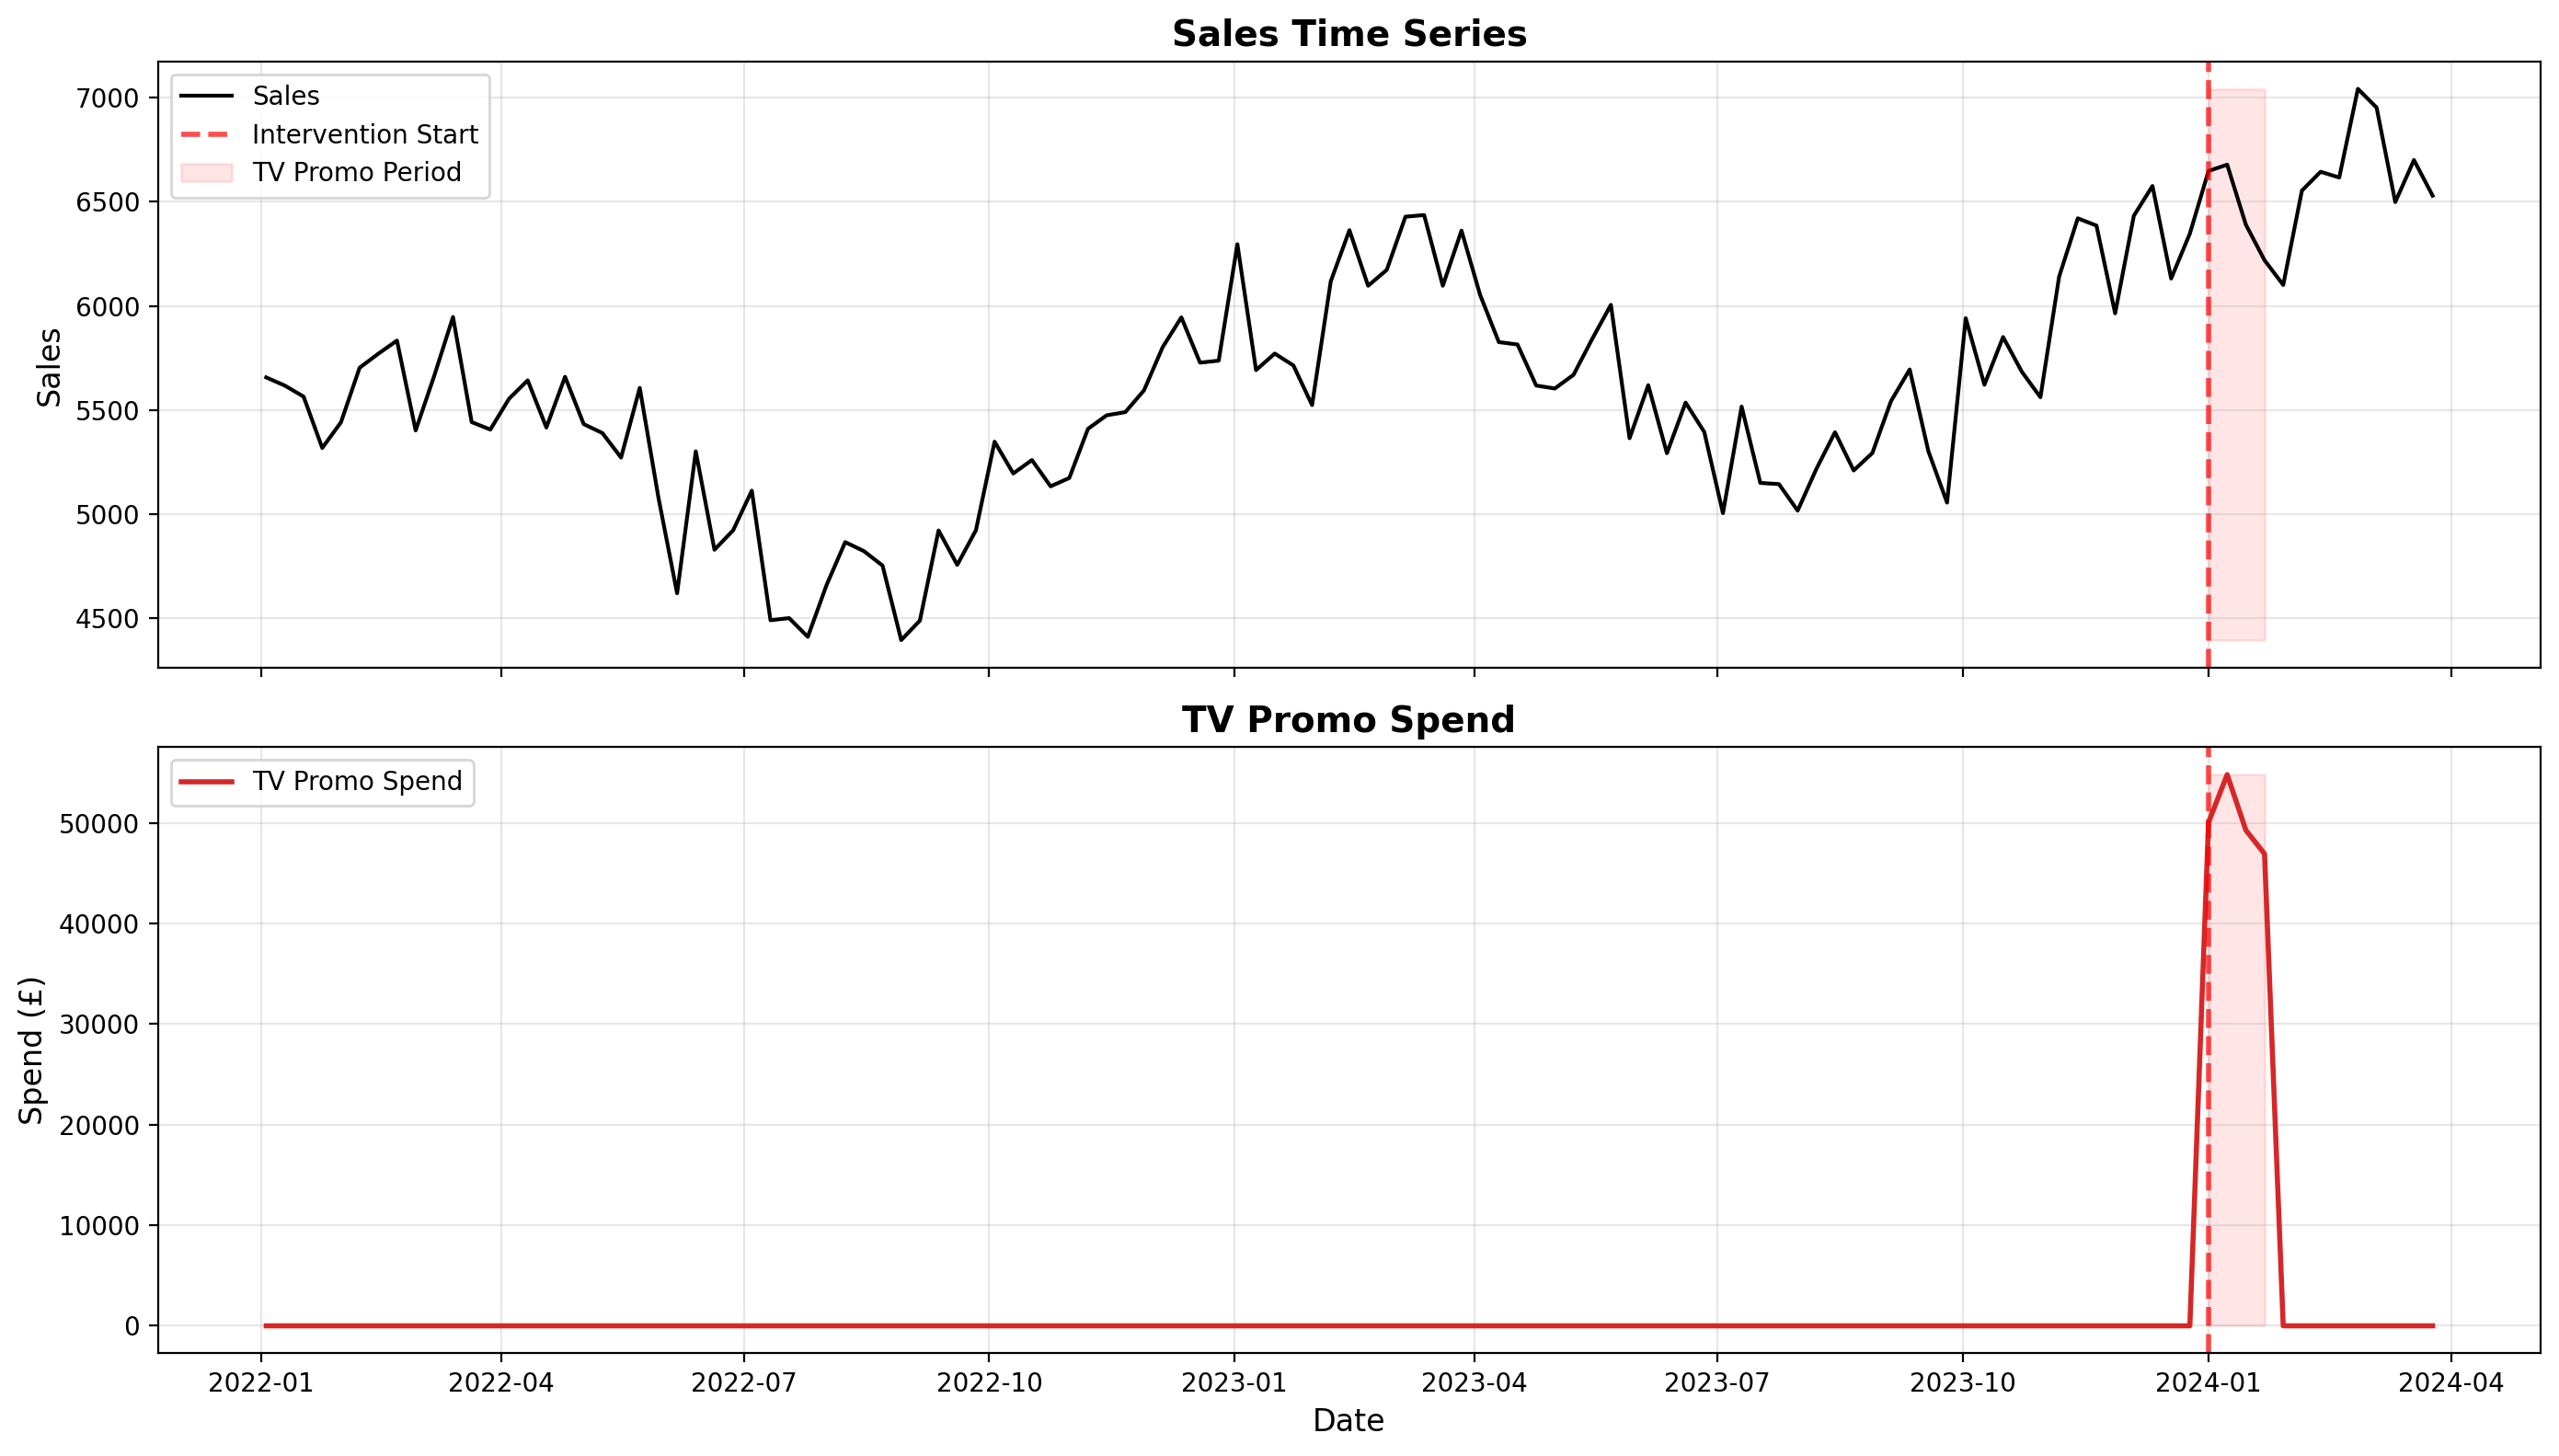

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot sales
ax1.plot(df.index, df["sales"], color="black", linewidth=1.5, label="Sales")
ax1.axvline(
    intervention_start,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Intervention Start",
)
ax1.fill_between(
    df.index[n_weeks_pre : n_weeks_pre + promo_weeks],
    df["sales"].min(),
    df["sales"].max(),
    color="red",
    alpha=0.1,
    label="TV Promo Period",
)
ax1.set_ylabel("Sales", fontsize=12)
ax1.set_title("Sales Time Series", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot TV promo spend for reference
ax2.plot(
    df_spend.index,
    df_spend["tv_promo"],
    color="#d62728",
    linewidth=2,
    label="TV Promo Spend",
)
ax2.axvline(intervention_start, color="red", linestyle="--", linewidth=2, alpha=0.7)
ax2.fill_between(
    df.index[n_weeks_pre : n_weeks_pre + promo_weeks],
    0,
    df_spend["tv_promo"].max(),
    color="red",
    alpha=0.1,
)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Spend (£)", fontsize=12)
ax2.set_title("TV Promo Spend", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()

## Part II: Interrupted Time Series Analysis

Now that we have our simulated data, we can use CausalPy's Interrupted Time Series method to estimate the causal impact of the TV promo campaign.

The key insight of ITS is:
1. We fit a model to the **pre-intervention** period (before the TV promo)
2. We use this model to predict what **would have happened** in the post-intervention period (the counterfactual)
3. We compare the actual observed sales to the counterfactual to estimate the causal impact

Note that we do **not** include the TV promo spend in our ITS model. We're trying to estimate the total impact of the intervention, regardless of which specific factors drove it. The ITS model will capture the baseline trends and seasonality to create an accurate counterfactual.


### Run the ITS Analysis

We'll fit a model that includes a time trend, monthly seasonality, and week-of-month effects to capture the baseline sales pattern.

The formula `"sales ~ 1 + t + C(month) + C(week_of_month)"` specifies a linear regression model with the following components:

- **`1`**: Intercept term (baseline level of sales)
- **`t`**: Linear time trend to capture long-term growth or decline
- **`C(month)`**: Categorical variable for month of year (1-12)
  - Creates 11 dummy variables (with one month as reference)
  - Captures annual seasonality patterns (e.g., higher sales in summer, lower in winter)
- **`C(week_of_month)`**: Categorical variable for week within month (1-5)
  - Creates 4 dummy variables (with week 1 as reference)
  - Captures within-month patterns (e.g., beginning vs end of month effects)

This modeling approach is deliberately simple and interpretable. We're using categorical variables rather than smooth functions (like splines or Fourier terms) because:
1. **Flexibility**: Each month and week can have its own level without constraining the pattern
2. **Robustness**: Less prone to overfitting than complex non-linear models
3. **Interpretability**: Easy to understand which time periods have higher/lower baseline sales

The key assumption is that these baseline patterns (trend + seasonality) would have continued unchanged in the post-intervention period if the TV promo hadn't occurred. Any deviation from this pattern is attributed to the campaign.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [9]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time=intervention_start,
    treatment_end_time=intervention_end,
    formula="sales ~ 1 + t + C(month) + C(week_of_month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


### Visualize the Results

The plot now shows the three-period design with:
- **Solid red line**: Intervention start (when the TV promo campaign began)
- **Dashed orange line**: Intervention end (when the 4-week campaign ended)

This allows us to visually distinguish between the intervention period (when the campaign was active) and the post-intervention period (after the campaign ended, showing any persistence effects from adstock).

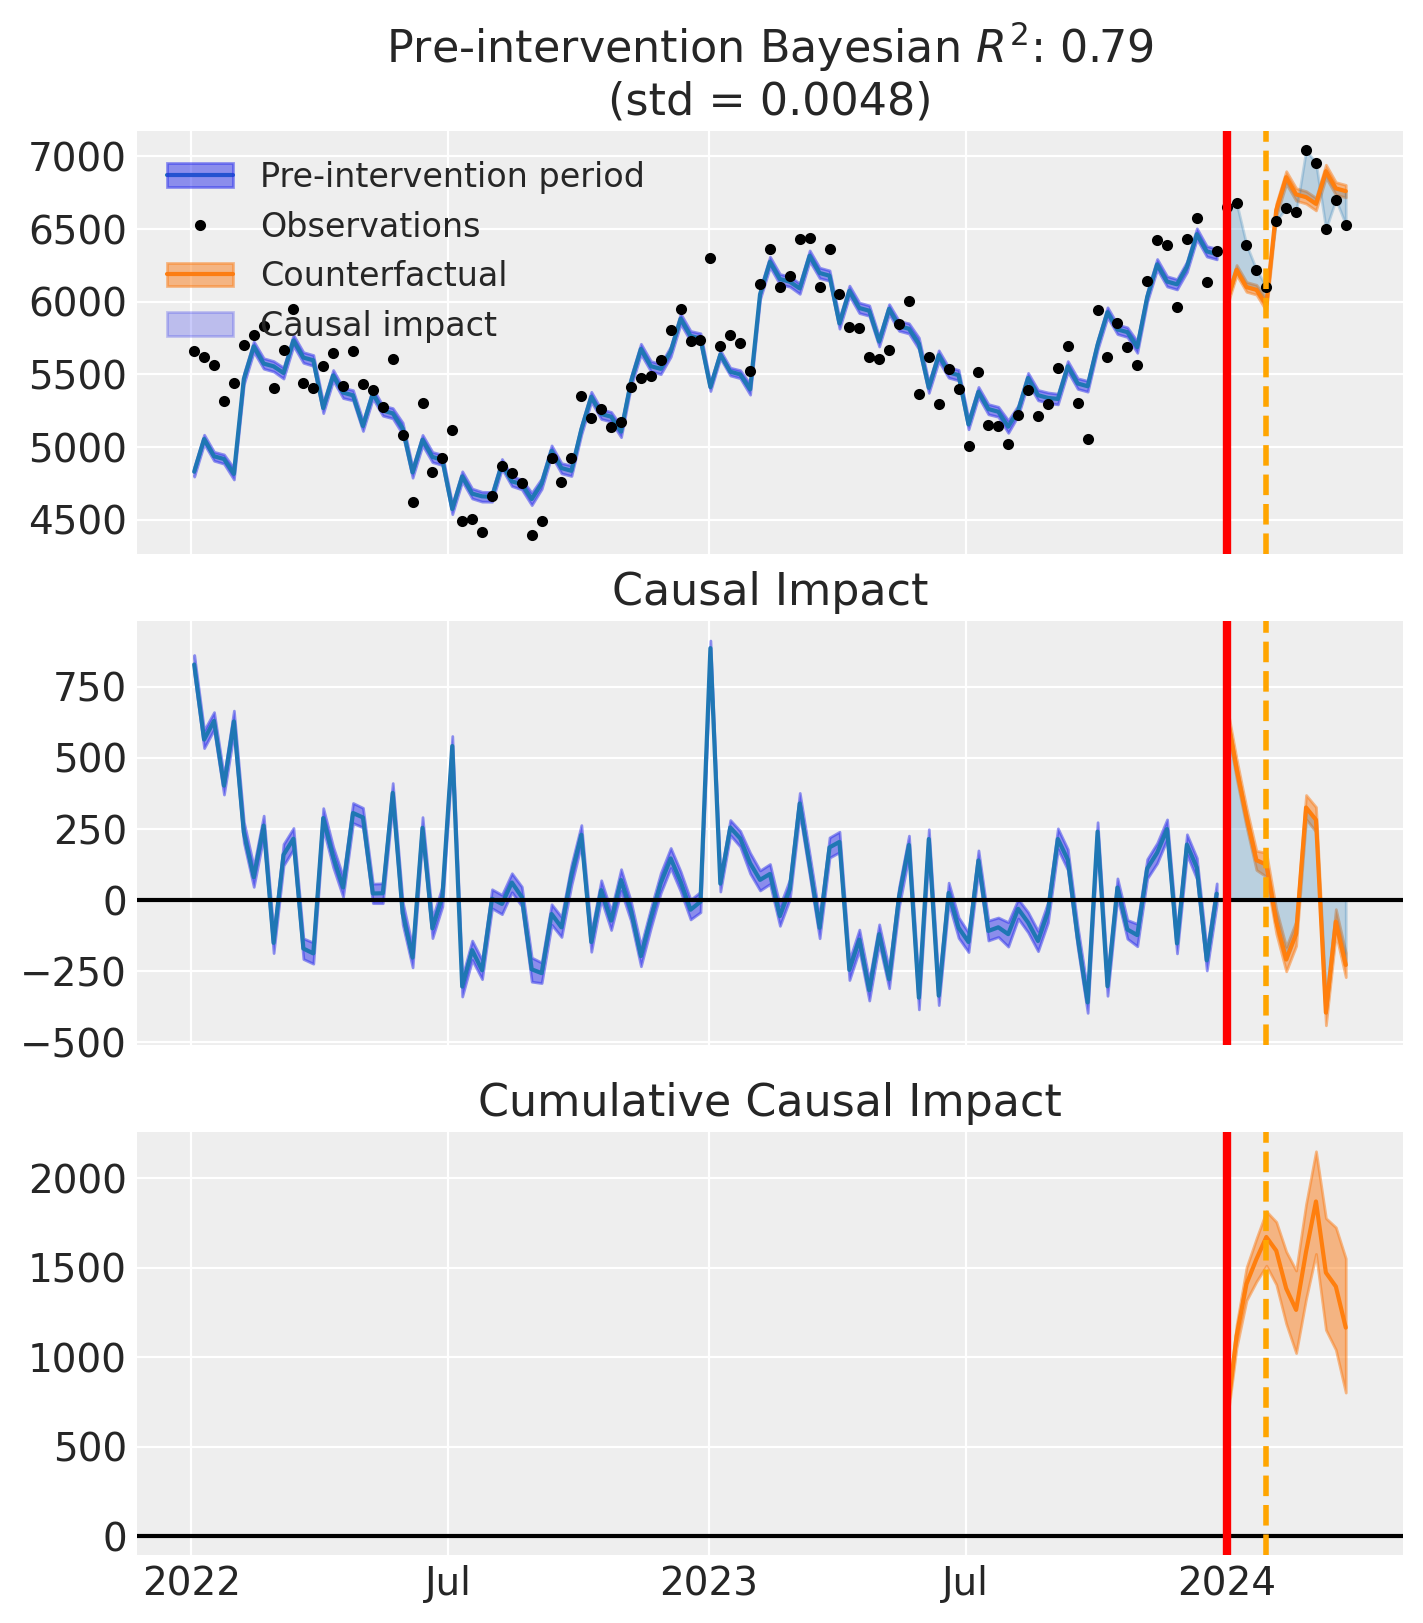

In [10]:
fig, ax = result.plot()

Let's also look at the model summary:


In [11]:
result.summary()

==================================Pre-Post Fit==================================
Formula: sales ~ 1 + t + C(month) + C(week_of_month)
Model coefficients:
    Intercept              4829, 94% HDI [4796, 4861]
    C(month)[T.2]          582, 94% HDI [546, 618]
    C(month)[T.3]          578, 94% HDI [543, 615]
    C(month)[T.4]          293, 94% HDI [257, 329]
    C(month)[T.5]          124, 94% HDI [90, 159]
    C(month)[T.6]          -251, 94% HDI [-289, -215]
    C(month)[T.7]          -548, 94% HDI [-584, -513]
    C(month)[T.8]          -509, 94% HDI [-543, -472]
    C(month)[T.9]          -473, 94% HDI [-512, -436]
    C(month)[T.10]         -146, 94% HDI [-181, -112]
    C(month)[T.11]         128, 94% HDI [90, 165]
    C(month)[T.12]         291, 94% HDI [254, 329]
    C(week_of_month)[T.2]  213, 94% HDI [187, 240]
    C(week_of_month)[T.3]  84, 94% HDI [59, 109]
    C(week_of_month)[T.4]  54, 94% HDI [29, 79]
    C(week_of_month)[T.5]  -60, 94% HDI [-96, -24]
    t              

### Fixed-period intervention analysis

:::{note}
This section is optional and not crucial for arriving at the lift test results. However, we show the analysis steps to get insights from fixed-period interventions because they can be insightful. See {doc}`its_post_intervention_analysis` for a complete example of fixed-period interventions.
:::

With the three-period design, we can now analyze effects separately for the intervention period (when the campaign was active) and the post-intervention period (after the campaign ended). This helps us understand both the immediate impact and any persistence effects.


In [12]:
# Intervention period (during the 4-week campaign)
intervention_summary = result.effect_summary(period="intervention")
print("Intervention Period Effect:")
print(intervention_summary.text)

print("\n" + "=" * 60 + "\n")

# Post-intervention period (after campaign ended)
post_summary = result.effect_summary(period="post")
print("Post-Intervention Period Effect:")
print(post_summary.text)

print("\n" + "=" * 60 + "\n")

# Comparison summary (shows persistence metrics)
comparison_summary = result.effect_summary(period="comparison")
print("Effect Persistence Analysis:")
print(comparison_summary.text)

Intervention Period Effect:
During the during intervention (2024-01-01 00:00:00 to 2024-01-22 00:00:00), the response variable had an average value of approx. 6484.26. By contrast, in the absence of an intervention, we would have expected an average response of 6097.54. The 95% interval of this counterfactual prediction is [6067.93, 6130.39]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is 386.72 with a 95% interval of [353.86, 416.32].

Summing up the individual data points during the during intervention, the response variable had an overall value of 25937.02. By contrast, had the intervention not taken place, we would have expected a sum of 24390.16. The 95% interval of this prediction is [24271.73, 24521.57].

The effect is statistically credible: the 95% HDI excludes zero, and the posterior probability of a increase is 1.000. Relative to the counterfactual, the effect repres

The `analyze_persistence()` method provides a comprehensive summary of how effects persist after the campaign ends:

In [13]:
persistence = result.analyze_persistence()

Effect Persistence Analysis

During intervention period:
  Mean effect: 386.72
  95% HDI: [353.86, 416.32]
  Total effect: 1546.86

Post-intervention period:
  Mean effect: -42.52
  95% HDI: [-73.78, -6.77]
  Total effect: -382.69

Persistence ratio: -0.110
  (-11.0% of intervention effect persisted)


## Part III: Calculating Lift Test Results

This section extracts the lift test results from our ITS analysis. The `result` object contains the post-intervention impact estimates in the `post_impact` attribute, which stores the full posterior distribution of the causal effect at each time point.

These results can be used in two ways:
1. **Immediate evaluation**: Assess this specific campaign's performance
2. **MMM calibration**: Feed these experimental results into your Media Mix Model to improve attribution accuracy


### 1. Absolute Lift (Primary Output for MMM Calibration)

The absolute lift is the total incremental units (sales, conversions, etc.) attributable to the intervention. This is calculated by summing the post-intervention impact across all post-intervention time points.

**For MMM Calibration**: The mean and standard deviation of this lift distribution are the key inputs needed. These tell your MMM:
- How much lift was actually observed from the campaign (mean)
- How uncertain we are about that estimate (standard deviation)

The MMM uses this information to calibrate its saturation curves, ensuring the model's predictions align with real-world experimental evidence.


Absolute Lift Summary:
               mean       sd   hdi_3%   hdi_97%
x[unit_0]  1164.168  202.671  801.195  1550.361

Most credible estimate: 1164.17 incremental sales
94% Credible Interval: [801.20, 1550.36]


Mean Lift Summary (Average Weekly Lift):
              mean      sd   hdi_3%  hdi_97%
x[unit_0]  291.042  50.668  200.299   387.59

Most credible estimate: 291.04 incremental sales per week
94% Credible Interval: [200.30, 387.59]


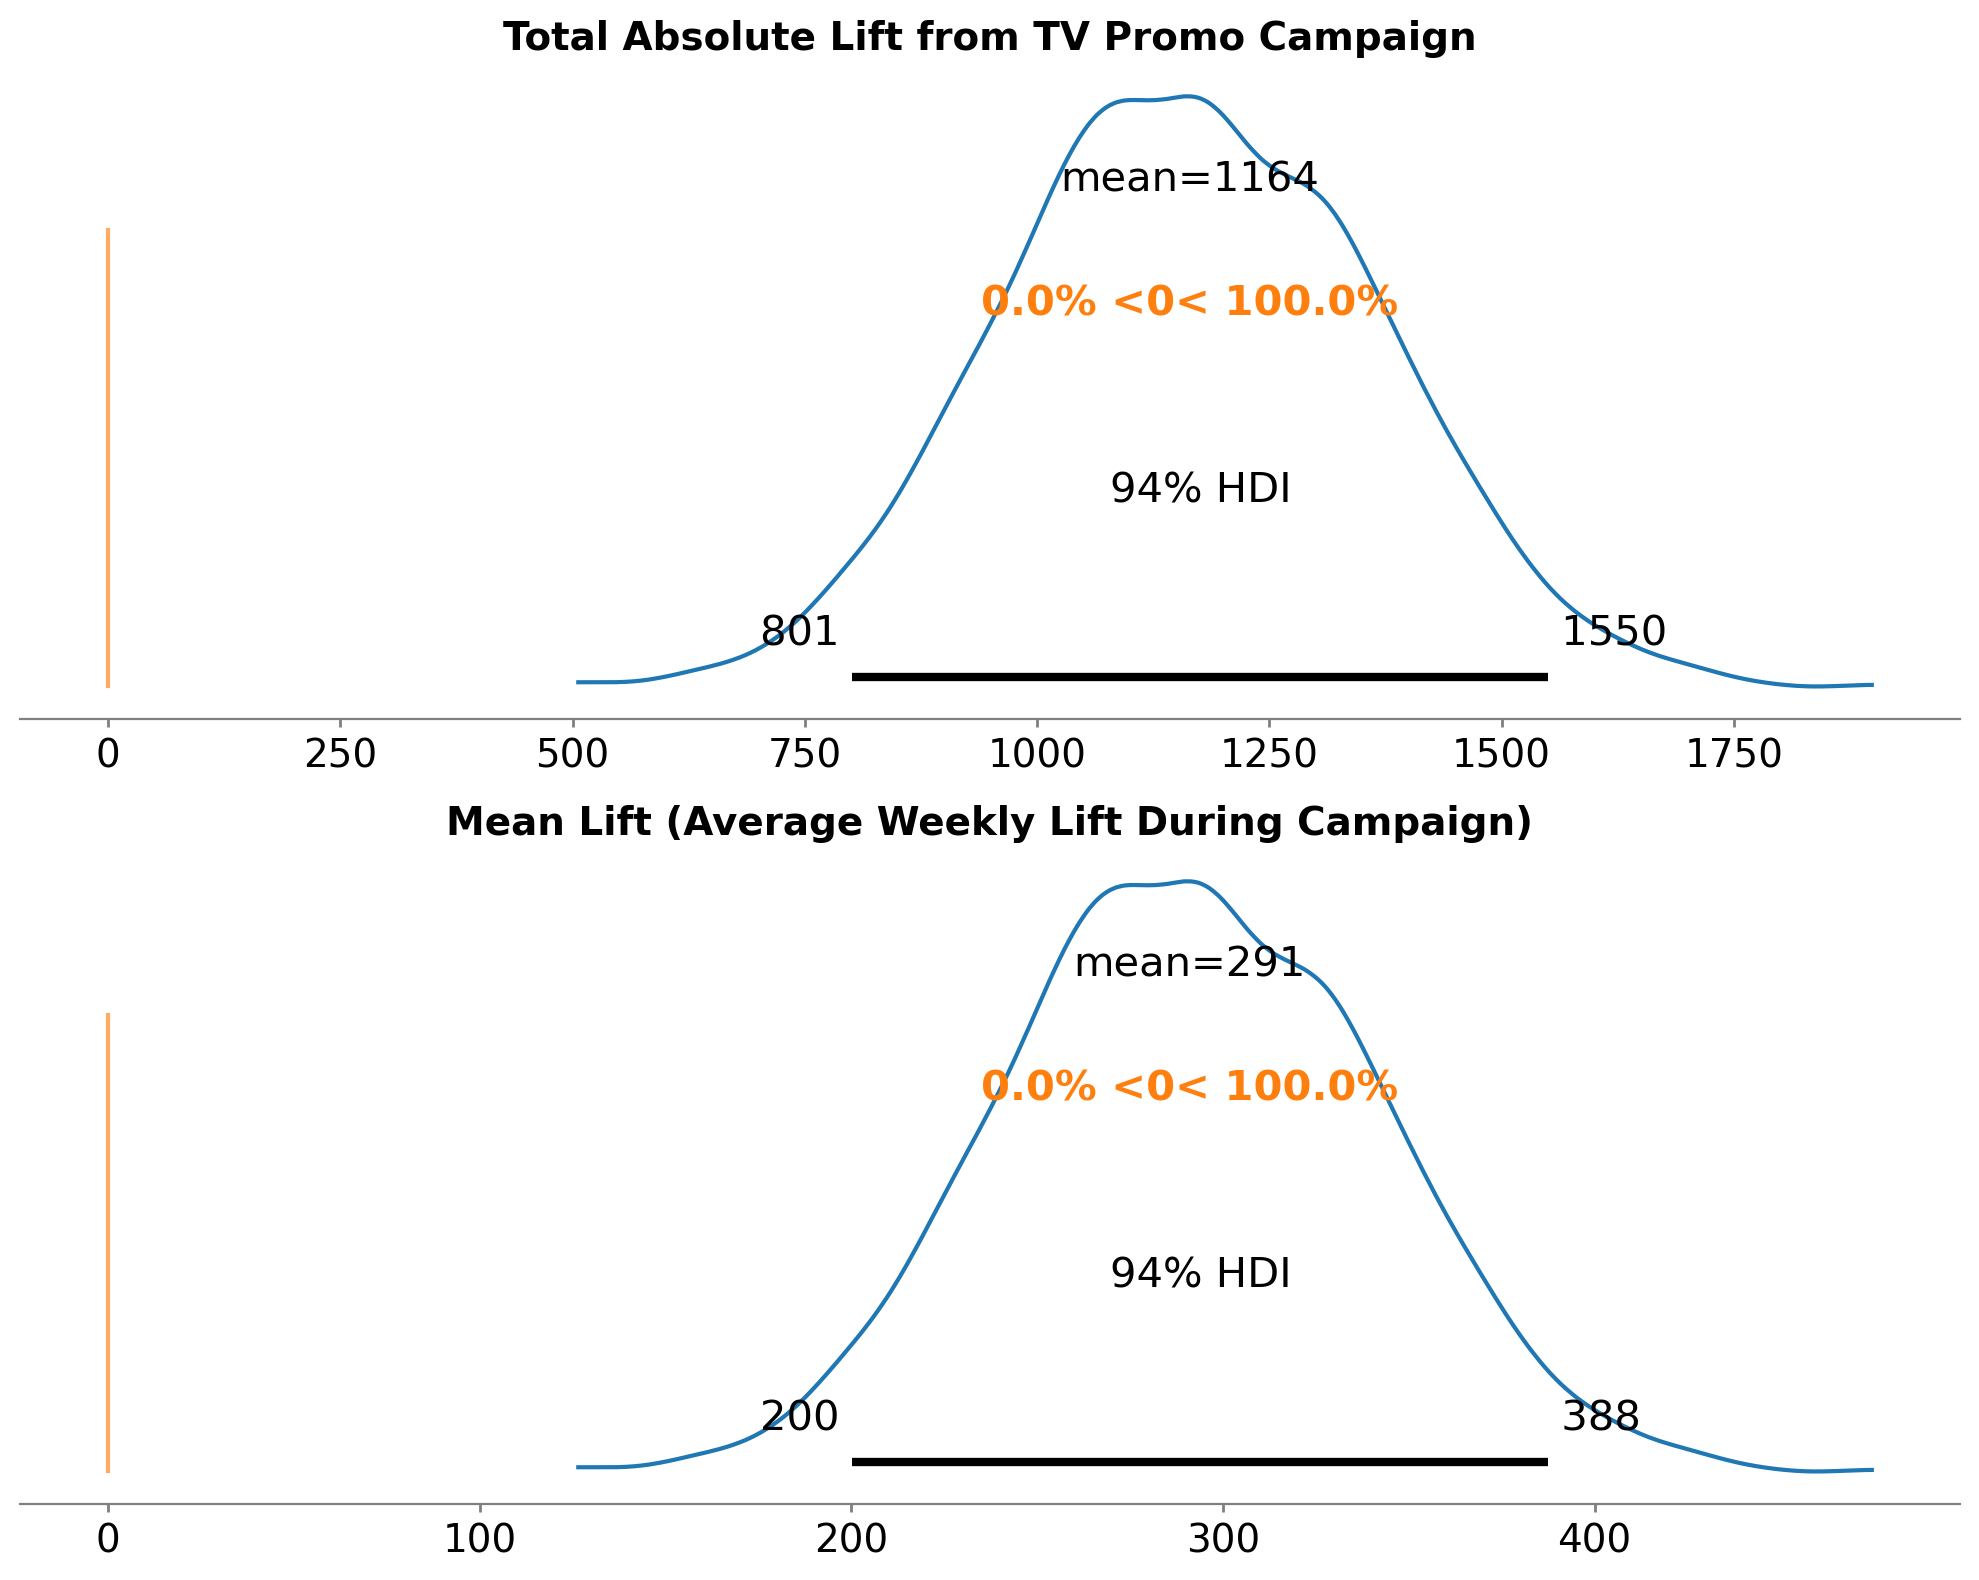

In [14]:
# Calculate total absolute lift
absolute_lift = result.post_impact.sum("obs_ind")

# Calculate mean lift (average weekly lift during the active campaign period)
# Note: We use the 4-week promotional period (promo_weeks) as the denominator.
# This represents the average lift per week during active spending, and deliberately
# excludes the post-campaign carryover effects from adstock.
experiment_length = promo_weeks  # 4 weeks
mean_lift = absolute_lift / experiment_length

# Visualize the posterior distributions
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Top panel: Absolute lift
az.plot_posterior(
    absolute_lift,
    ref_val=0,
    hdi_prob=0.94,
    round_to=2,
    ax=axes[0],
)
axes[0].set_title(
    "Total Absolute Lift from TV Promo Campaign", fontsize=14, fontweight="bold"
)

# Bottom panel: Mean lift
az.plot_posterior(
    mean_lift,
    ref_val=0,
    hdi_prob=0.94,
    round_to=2,
    ax=axes[1],
)
axes[1].set_title(
    "Mean Lift (Average Weekly Lift During Campaign)", fontsize=14, fontweight="bold"
)

plt.tight_layout()

# Get summary statistics
absolute_lift_summary = az.summary(absolute_lift, kind="stats")
mean_lift_summary = az.summary(mean_lift, kind="stats")

print("\nAbsolute Lift Summary:")
print(absolute_lift_summary)
print(f"\nMost credible estimate: {absolute_lift.mean().values:.2f} incremental sales")
print(
    f"94% Credible Interval: [{absolute_lift_summary['hdi_3%'].values[0]:.2f}, {absolute_lift_summary['hdi_97%'].values[0]:.2f}]"
)

print("\n" + "=" * 60)
print("\nMean Lift Summary (Average Weekly Lift):")
print(mean_lift_summary)
print(
    f"\nMost credible estimate: {mean_lift.mean().values:.2f} incremental sales per week"
)
print(
    f"94% Credible Interval: [{mean_lift_summary['hdi_3%'].values[0]:.2f}, {mean_lift_summary['hdi_97%'].values[0]:.2f}]"
)

:::{admonition} Key Outputs for MMM Calibration
:class: important

From the lift calculations above, extract these values for MMM calibration:

- **Mean Lift (delta_y)**: The `mean` value from the **Mean Lift Summary** table (e.g., 290.60 incremental sales per week). This represents the average weekly lift during the 4-week promotional period.
- **Standard Deviation (sigma)**: The `sd` value from the **Mean Lift Summary** table (e.g., 49.76)
- **Spend Increment (delta_x)**: The weekly spend during the test - can be expressed as:
  - **Absolute**: £50,000/week (actual spend during promo)
  - **Normalized**: Depends on your MMM's scaling (e.g., if max weekly spend in your data is £150k, then 50k/150k = 0.33)
- **Baseline Spend (x)**: The spend level before the increment - in this case, £0 for tv_promo (or 0.0 normalized)

**Important Notes**: 
- The choice between absolute and normalized values depends on how your MMM preprocesses media spend data. If your MMM normalizes spend by dividing by the maximum, use normalized values. If it uses raw spend, use absolute values.
- We use **mean lift** (average weekly lift) rather than absolute lift because MMM calibration typically expects the response per unit of time at a given spend level. This focuses on the 4-week active campaign period and excludes post-campaign carryover effects, providing a cleaner signal for calibrating saturation curves.

Example formatting for PyMC-Marketing (which does _not_ require normalized values):

```python
# Extract mean lift statistics from the ITS analysis
mean_lift_mean = mean_lift_summary['mean'].values[0]
mean_lift_sd = mean_lift_summary['sd'].values[0]

# Calculate average weekly spend during the promo period
promo_spend_weekly = df_spend.loc[
    (df_spend.index >= intervention_start) & 
    (df_spend.index < intervention_start + pd.Timedelta(weeks=promo_weeks)), 
    'tv_promo'
].mean()

# Create lift test dataframe for MMM calibration
lift_test_df = pd.DataFrame({
    "channel": ["tv_promo"],
    "x": [0.0],  # Baseline spend for tv_promo - it's zero before test
    "delta_x": [promo_spend_weekly],  # Spend increment (weekly)
    "delta_y": [mean_lift_mean],  # Mean lift from ITS result (average weekly lift)
    "sigma": [mean_lift_sd]  # Std of mean lift from ITS result
})
```

See the [PyMC-Marketing lift test calibration guide](https://www.pymc-marketing.io/en/latest/notebooks/mmm/mmm_lift_test.html) for complete integration details.
:::


### 2. Percentage Lift

The percentage lift tells us by what percentage the campaign increased sales compared to what would have happened without it. This is calculated as: 

$$\text{Percentage Lift} = \frac{\text{Observed Sales} - \text{Counterfactual Sales}}{\text{Counterfactual Sales}} \times 100$$



Percentage Lift Summary:
            mean     sd  hdi_3%  hdi_97%
x[unit_0]  1.556  0.243   1.088    1.987

Most credible estimate: 1.56% lift
94% Credible Interval: [1.09%, 1.99%]


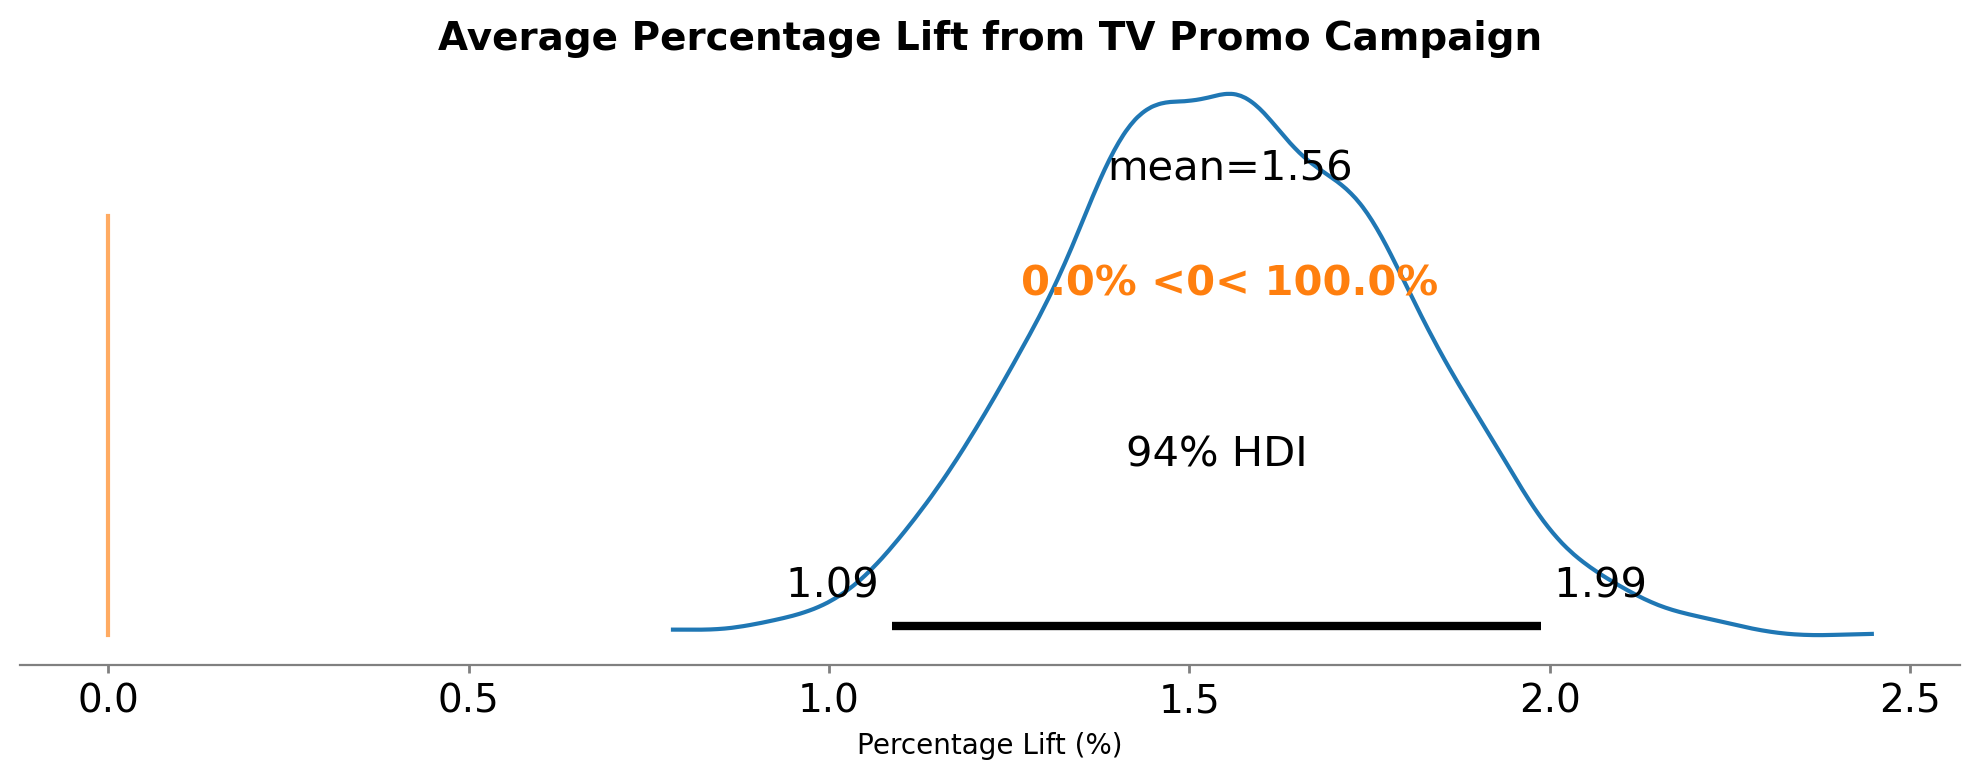

In [15]:
# Get observed sales in post-intervention period
post_intervention_sales = df.loc[df.index >= intervention_start, "sales"].values

# Get counterfactual predictions (mu is the predicted mean)
# The counterfactual is stored in result.post_pred
counterfactual_sales = result.post_pred["posterior_predictive"]["mu"]

# Calculate percentage lift for each draw
# Percentage lift = (observed - counterfactual) / counterfactual * 100
percentage_lift = (result.post_impact / counterfactual_sales) * 100

# Average percentage lift across the post-intervention period
avg_percentage_lift = percentage_lift.mean("obs_ind")

# Visualize
fig, ax = plt.subplots(figsize=(10, 4))
az.plot_posterior(
    avg_percentage_lift,
    ref_val=0,
    hdi_prob=0.94,
    round_to=3,
    ax=ax,
)
ax.set_title(
    "Average Percentage Lift from TV Promo Campaign", fontsize=14, fontweight="bold"
)
ax.set_xlabel("Percentage Lift (%)")
plt.tight_layout()

# Summary statistics
percentage_lift_summary = az.summary(avg_percentage_lift, kind="stats")
print("\nPercentage Lift Summary:")
print(percentage_lift_summary)
print(f"\nMost credible estimate: {avg_percentage_lift.mean().values:.2f}% lift")
print(
    f"94% Credible Interval: [{percentage_lift_summary['hdi_3%'].values[0]:.2f}%, {percentage_lift_summary['hdi_97%'].values[0]:.2f}%]"
)

### 3. Return on Investment (ROI)

Finally, let's calculate the ROI of the TV promo campaign. We need to:
1. Calculate the total spend on the TV promo campaign
2. Calculate the incremental revenue (absolute lift × revenue per unit)
3. Compute ROI as: $\text{ROI} = \frac{\text{Incremental Revenue} - \text{Campaign Spend}}{\text{Campaign Spend}} \times 100$

For this example, let's assume each unit of sales generates £230 in revenue.


Total TV Promo Spend: £201,082.33

ROI Summary:
             mean      sd  hdi_3%  hdi_97%
x[unit_0]  33.159  23.182  -8.358   77.332

Most credible estimate: 33.16% ROI
94% Credible Interval: [-8.36%, 77.33%]

--- Financial Summary ---
Campaign Spend: £201,082.33
Incremental Revenue (mean): £267,758.69
Net Profit (mean): £66,676.36


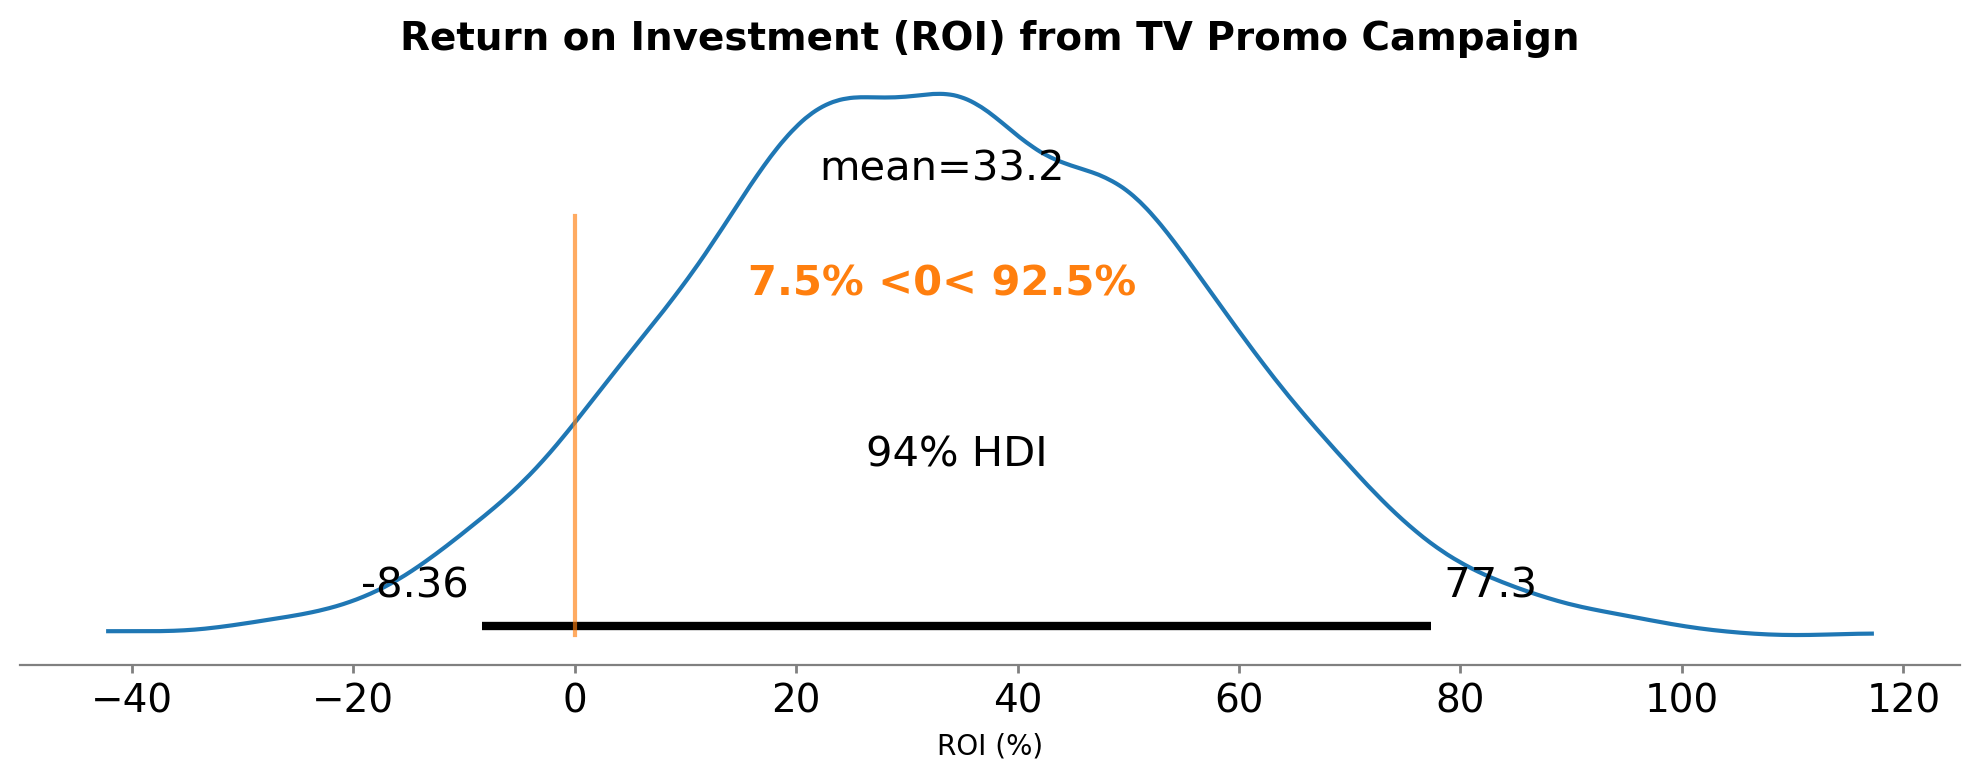

In [16]:
# Calculate total TV promo spend
total_tv_promo_spend = df_spend["tv_promo"].sum()
print(f"Total TV Promo Spend: £{total_tv_promo_spend:,.2f}")

# Revenue per unit
revenue_per_unit = 230

# Calculate incremental revenue
# For each posterior sample, calculate revenue
incremental_revenue = absolute_lift * revenue_per_unit

# Calculate ROI for each posterior sample
# ROI = (Incremental Revenue - Spend) / Spend * 100
roi = ((incremental_revenue - total_tv_promo_spend) / total_tv_promo_spend) * 100

# Visualize ROI distribution
fig, ax = plt.subplots(figsize=(10, 4))
az.plot_posterior(
    roi,
    ref_val=0,
    hdi_prob=0.94,
    round_to=3,
    ax=ax,
)
ax.set_title(
    "Return on Investment (ROI) from TV Promo Campaign", fontsize=14, fontweight="bold"
)
ax.set_xlabel("ROI (%)")
plt.tight_layout()

# Summary statistics
roi_summary = az.summary(roi, kind="stats")
print("\nROI Summary:")
print(roi_summary)
print(f"\nMost credible estimate: {roi.mean().values:.2f}% ROI")
print(
    f"94% Credible Interval: [{roi_summary['hdi_3%'].values[0]:.2f}%, {roi_summary['hdi_97%'].values[0]:.2f}%]"
)

# Also show the incremental revenue
print("\n--- Financial Summary ---")
print(f"Campaign Spend: £{total_tv_promo_spend:,.2f}")
print(f"Incremental Revenue (mean): £{incremental_revenue.mean().values:,.2f}")
print(
    f"Net Profit (mean): £{(incremental_revenue.mean().values - total_tv_promo_spend):,.2f}"
)

## Summary and Interpretation

### What Did We Learn from This Lift Test?

Using Interrupted Time Series analysis, we successfully conducted a lift test and generated experimental evidence about the TV promo campaign's causal impact. Here's what we extracted:

**Primary Lift Test Output (for MMM Calibration):**
- **Absolute Lift**: Mean = ~1,162 incremental sales, SD = ~199 sales
- These values (mean and SD) can be directly fed into MMM calibration procedures

**Additional Business Insights:**
- **Percentage Lift**: Approximately 1.4% average lift over the post-intervention period
- **ROI**: Approximately 33% return on investment, with wide credible intervals reflecting uncertainty

This experimental evidence provides ground truth data that your MMM can use to calibrate its response curves, ensuring the model's predictions align with real-world results.

### The Power of Adstock Effects

Notice in the middle panel of the ITS plot that the impact doesn't immediately drop to zero after the 4-week campaign ends. This is because:
1. The **adstock effect** means that TV advertising has carryover—people remember the ads for weeks after seeing them
2. Our ITS model captures this delayed impact by measuring the difference between observed and counterfactual sales throughout the entire post-intervention period

This is exactly why we included 3 months of post-intervention data rather than just the 4 weeks of active spending.


### Business Implications

This analysis provides actionable insights for marketing decision-makers:

1. **Campaign Effectiveness**: The credible intervals tell us how confident we can be in the lift estimates. Narrow intervals mean more certainty; wide intervals suggest more uncertainty and possibly a need for more data or a larger effect size.

2. **Budget Optimization**: The ROI metric directly informs whether similar campaigns should be repeated, scaled up, or reconsidered. A positive ROI (with credible intervals excluding zero) provides strong evidence for continuing the strategy.

3. **Separating Baseline from Promo**: By keeping baseline TV brand awareness separate from the promo campaign, we can accurately attribute the incremental lift to the specific intervention rather than confounding it with ongoing activities.

4. **Future Experiments**: If the credible intervals are wide, consider running similar campaigns in different time periods to gather more evidence, or consider increasing the campaign intensity to create a larger, more detectable signal.


### Assumptions and Limitations

As with any causal inference method, ITS relies on certain assumptions:

**Key Assumptions:**
1. **No Other Interventions**: We assume no other major changes occurred at the same time as the TV promo campaign. If a competitor launched a major product or there was an economic shock, this could bias our estimates.

2. **Correct Model Specification**: Our ITS model includes trend and seasonality. If the pre-intervention data has other patterns (e.g., sudden regime changes, non-linear trends), we'd need to adjust the model accordingly.

3. **Stable Relationships**: We assume the relationship between time, seasonality, and sales would have continued in the same pattern without the intervention.

**Limitations:**
- **Single Time Series**: Unlike geographic experiments (e.g., GeoLift), we only have one time series, so we can't control for contemporaneous shocks that affect all units equally.
- **No Synthetic Control**: If we had similar control markets, we could use Synthetic Control methods for additional robustness.
- **Effect Heterogeneity**: ITS gives us an average treatment effect. If the effect varied over time in complex ways, we might need more sophisticated time-varying effect models.

Despite these limitations, ITS remains one of the best tools available when geographic controls are unavailable.


### Using Lift Test Results for MMM Calibration

The primary purpose of running lift tests is to generate experimental evidence that can improve your Media Mix Models. Here's how to use these results:

#### 1. Feed Results into MMM Calibration

The mean and standard deviation of the absolute lift (extracted above) can be directly integrated into MMM frameworks like PyMC-Marketing using the `add_lift_test_measurements()` method. This:
- Constrains the MMM's saturation curves to match observed experimental data
- Improves parameter identifiability, especially for correlated channels
- Provides more accurate attribution and ROI estimates

See the [PyMC-Marketing lift test calibration documentation](https://www.pymc-marketing.io/en/latest/notebooks/mmm/mmm_lift_test.html) for implementation details.

#### 2. Run Multiple Lift Tests

To get the most value from lift testing:
- Test **different channels** to calibrate each saturation curve
- Test at **different spend levels** to better define the curve shape
- Run tests in **different time periods** to capture seasonal variations
- Accumulate results over time to build a robust calibration dataset

#### 3. Additional Extensions

- **Incorporating Other Data**: Include additional predictors (weather, competitors, events) in the ITS model to improve counterfactual accuracy
- **Time-Varying Effects**: Examine `result.post_impact` at individual time points to understand how effects decay over time
- **Hierarchical Models**: If you have multiple products or sub-markets, pool information across units while estimating unit-specific lift


## Conclusion

This notebook demonstrated how to conduct lift tests using Interrupted Time Series analysis when traditional control groups are unavailable. We showed how ITS can measure the causal impact of a national TV campaign, extracting the key statistical outputs (mean lift and standard deviation) that are essential for Media Mix Model calibration. Beyond these primary outputs, we also calculated percentage lift and ROI to provide immediate business insights for decision-makers.

The importance of lift testing extends beyond measuring individual campaigns. Lift tests provide experimental evidence that validates whether your marketing actually works, separating signal from noise in your attribution models. When these experimental results are fed into MMM calibration procedures, they constrain the model's saturation curves to match real-world observations, dramatically improving parameter identifiability—especially for correlated channels where the model might otherwise struggle to distinguish their individual effects. This leads to more accurate attribution estimates and better-informed budget allocation decisions.

:::{admonition} The Complete Lift Testing Workflow
:class: tip

For a complete marketing analytics workflow, lift testing fits into a three-step process:

1. **Run lift tests** (this notebook) → Generate experimental evidence using ITS to measure the true causal impact of campaigns
2. **Calibrate your MMM** → Feed lift test results into your Media Mix Model using methods like PyMC-Marketing's `add_lift_test_measurements()` to constrain model parameters
3. **Optimize budget** → Use the calibrated MMM to allocate marketing spend across channels with confidence that the model reflects real-world effectiveness

This approach bridges the gap between experimental causal inference and predictive modeling, combining the rigor of randomized experiments with the practical needs of ongoing attribution and optimization.
:::

The method shown here is particularly valuable for national-level campaigns where geographic controls don't exist, but it can be extended in several ways. Multiple lift tests can be accumulated over time—testing different channels, different spend levels, and different time periods—to build a robust calibration dataset. The ITS model itself can be enhanced by incorporating additional predictors like weather, competitor activity, or special events to improve the counterfactual's accuracy. For organizations with multiple products or sub-markets, hierarchical Bayesian models can pool information across units while still estimating unit-specific lift.

Ultimately, this approach represents a practical solution to one of marketing's most challenging problems: measuring incrementality when traditional experimental designs aren't feasible. By combining the strengths of time series analysis with Bayesian uncertainty quantification, we can generate the experimental evidence needed to build better attribution models and make more confident investment decisions.